In [1]:
# Importing necessary libraries
import tensorflow as tf
import tarfile
import os
import matplotlib.pyplot as plt
from preprocessDefinition import preprocess

In [2]:
# Constants Assumed
NUM_CLASSES = 358
BATCH_SIZE = 32
IMAGE_SIZE = 299
EPOCHS_PHASE1 = 5
EPOCHS_PHASE2 = 5
TRAIN_SIZE = 7160   # 20 images x 358 classes
VAL_SIZE = 3580     # 10 images x 358 classes

In [3]:
# Parsing tfrecord
def parse_examples(serialized_examples):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'birdType': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_example(serialized_examples, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    label = example['birdType']
    return image, label

In [4]:
# Creating function that loads Dataset provided
def load_dataset(tfrecord_path, repeat=False):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parse_examples, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = load_dataset('birds-20-eachOf-358.tfrecords', repeat=True)
val_dataset = load_dataset('birds-10-eachOf-358.tfrecords')

In [5]:
# Using Pretrained model : Xception
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_model.trainable = False

In [6]:
# Classification Head
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [7]:
# Metrics to evaluate
top5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5")
top10 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name="top10")
top20 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20, name="top20")

In [8]:
# Compiler for Phase 1 - Freezing Base Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', top5, top10, top20]
)

In [9]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_birder.keras', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
]

In [10]:
# Training Phase 1
history1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS_PHASE1,
    steps_per_epoch=TRAIN_SIZE // BATCH_SIZE,
    validation_steps=VAL_SIZE // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 1937s 9s/step - accuracy: 0.1201 - loss: 5.7579 - top10: 0.3939 - top20: 0.5035 - top5: 0.2890 - val_accuracy: 0.2694 - val_loss: 4.6391 - val_top10: 0.7168 - val_top20: 0.8249 - val_top5: 0.5833
Epoch 2/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 2388s 11s/step - accuracy: 0.2887 - loss: 4.0552 - top10: 0.7382 - top20: 0.8478 - top5: 0.6079 - val_accuracy: 0.3432 - val_loss: 3.6947 - val_top10: 0.7849 - val_top20: 0.8801 - val_top5: 0.6681
Epoch 3/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 2205s 10s/step - accuracy: 0.3744 - loss: 3.4367 - top10: 0.8272 - top20: 0.9099 - top5: 0.7080 - val_accuracy: 0.3773 - val_loss: 3.4117 - val_top10: 0.8119 - val_top20: 0.8939 - val_top5: 0.7044
Epoch 4/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 2811s 13s/step - accuracy: 0.4233 - loss: 3.0785 - top10: 0.8749 - top20: 0.9400 - top5: 0.7723 - val_accuracy: 0.3891 - val_loss: 3.3135 - val_top10: 0.8190 - val_top20: 0.8916 - val_top5: 0.7154
Epoch 5/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 2238s 10s/step - a

In [11]:
# Phase 2 - Unfreezing last 30 layers and fine tuning them due to less computational power
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', top5, top10, top20]
)

history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    initial_epoch=EPOCHS_PHASE1,
    epochs=EPOCHS_PHASE1 + EPOCHS_PHASE2,
    steps_per_epoch=TRAIN_SIZE // BATCH_SIZE,
    validation_steps=VAL_SIZE // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2813s 12s/step - accuracy: 0.5018 - loss: 2.7245 - top10: 0.8792 - top20: 0.9367 - top5: 0.7889 - val_accuracy: 0.4119 - val_loss: 3.2291 - val_top10: 0.8263 - val_top20: 0.8970 - val_top5: 0.7289
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2834s 13s/step - accuracy: 0.5650 - loss: 2.4671 - top10: 0.9357 - top20: 0.9710 - top5: 0.8639 - val_accuracy: 0.4386 - val_loss: 3.0724 - val_top10: 0.8407 - val_top20: 0.9043 - val_top5: 0.7449
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2939s 13s/step - accuracy: 0.5900 - loss: 2.3487 - top10: 0.9455 - top20: 0.9784 - top5: 0.8826 - val_accuracy: 0.4502 - val_loss: 3.0129 - val_top10: 0.8460 - val_top20: 0.9074 - val_top5: 0.7556
Epoch 9/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2816s 13s/step - accuracy: 0.6162 - loss: 2.2361 - top10: 0.9504 - top20: 0.9802 - top5: 0.9001 - val_accuracy: 0.4538 - val_loss: 2.9798 - val_top10: 0.8477 - val_top20: 0.9065 - val_top5: 0.7624
Epoch 10/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2816s 13s/s

In [12]:
# Saving final models
model.save('birderModel.keras')
with tarfile.open('birderModel.tgz', 'w:gz') as tar:
    tar.add('birderModel.keras', arcname='birderModel.keras')

In [13]:
# Evaluating results for comparison
results = model.evaluate(val_dataset, steps=VAL_SIZE // BATCH_SIZE)
top1, top5, top10, top20 = results[1], results[2], results[3], results[4]
average = (top1 + top5 + top10 + top20) / 4

print(f"Top-1 Accuracy:  {top1 * 100:.2f}%")
print(f"Top-5 Accuracy:  {top5 * 100:.2f}%")
print(f"Top-10 Accuracy: {top10 * 100:.2f}%")
print(f"Top-20 Accuracy: {top20 * 100:.2f}%")
print(f"Average Top-K Accuracy: {average * 100:.2f}%")

111/111 ━━━━━━━━━━━━━━━━━━━━ 627s 6s/step - accuracy: 0.4566 - loss: 2.9528 - top10: 0.8491 - top20: 0.9077 - top5: 0.7646
Top-1 Accuracy:  45.66%
Top-5 Accuracy:  76.46%
Top-10 Accuracy: 84.91%
Top-20 Accuracy: 90.77%
Average Top-K Accuracy: 74.45%


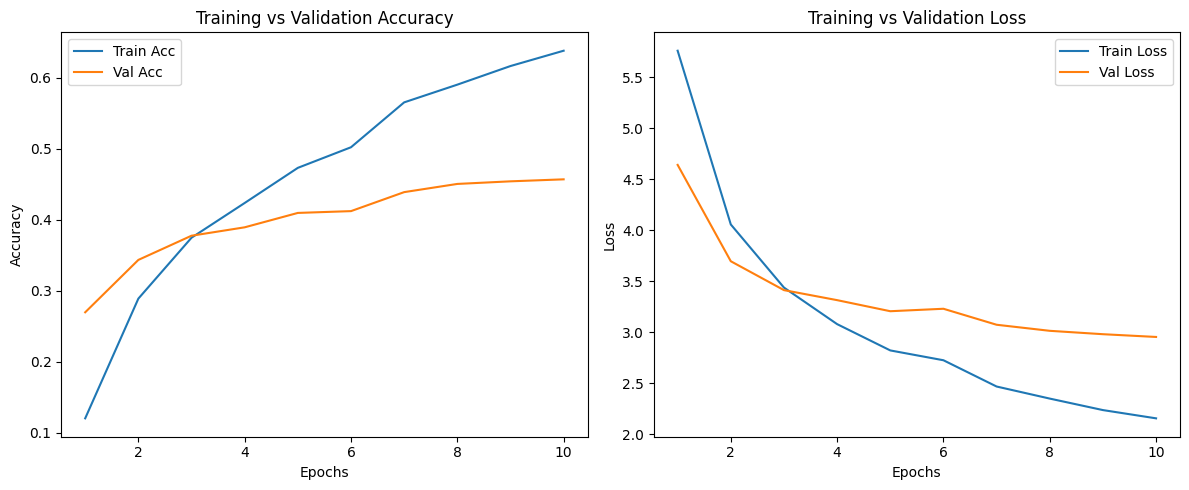

In [14]:
# Plotting Training vs Validation Accuracy and Loss
history = history1.history
for k, v in history2.history.items():
    if k in history:
        history[k] += v
    else:
        history[k] = v

epochs_range = range(1, len(history['accuracy']) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['accuracy'], label='Train Acc')
plt.plot(epochs_range, history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()